In [1]:
from __future__ import division, print_function
import collections
import os

import nltk
import numpy as np
from keras.callbacks import TensorBoard
from keras.layers import Activation, Dense, Dropout, Embedding, LSTM
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import codecs

Using TensorFlow backend.


In [2]:
DATA_DIR = "./data"
LOG_DIR = "./logs"

In [3]:
MAX_FEATURES = 2000
MAX_SENTENCE_LENGTH = 40

EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10

In [4]:
# 訓練データの読み込み、語彙の作成
maxlen = 0                         # 一文の単語の数
word_freqs = collections.Counter() # 各単語の出現数
num_recs = 0                       # 行数
with codecs.open(os.path.join(DATA_DIR, "umich-sentiment-train.txt"), "r",
                 'utf-8') as ftrain:
    for line in ftrain:
        label, sentence = line.strip().split("\t")
        try:
            # 単語に分割
            words = nltk.word_tokenize(sentence.lower())
        except LookupError:
            print("Englisth tokenize does not downloaded. So download it.")
            nltk.download("punkt")
            words = nltk.word_tokenize(sentence.lower())
        maxlen = max(maxlen, len(words))
        for word in words:
            word_freqs[word] += 1
        num_recs += 1

In [5]:
# コーパスのからの情報
print(maxlen)            # 42
print(len(word_freqs))   # 2313
print(num_recs)          # 7086

42
2326
7086


In [6]:
# 1 is UNK, 0 is PAD
# 語彙数を2002後に設定(※UNKとPAD含む)
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
# 頻出度の高い順位語彙を抜き出し、ルックアップテーブルを作成
word2index = {x[0]: i+2 for i, x in
              enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0
word2index["UNK"] = 1
# インデックスから単語を参照する、ルックアップテーブル
index2word = {v: k for k, v in word2index.items()}

In [7]:
# 入力文を単語インデックス系列に変換
X = np.empty((num_recs, ), dtype=list)
y = np.zeros((num_recs, ))
i = 0
with codecs.open(os.path.join(DATA_DIR, "umich-sentiment-train.txt"),
                 'r', 'utf-8') as ftrain:
    for line in ftrain:
        label, sentence = line.strip().split("\t")
        words = nltk.word_tokenize(sentence.lower())
        seqs = []
        for word in words:
            if word in word2index:
                seqs.append(word2index[word])
            else:
                seqs.append(word2index["UNK"])
        X[i] = seqs
        y[i] = int(label)
        i += 1

In [8]:
# Pad the sequences (left padded with zeros)
X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)

In [9]:
# Split input into training and test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2,
                                                random_state=42)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(5668, 40) (1418, 40) (5668,) (1418,)


In [10]:
# Build model
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE,
                    input_length=MAX_SENTENCE_LENGTH))
model.add(Dropout(0.5))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

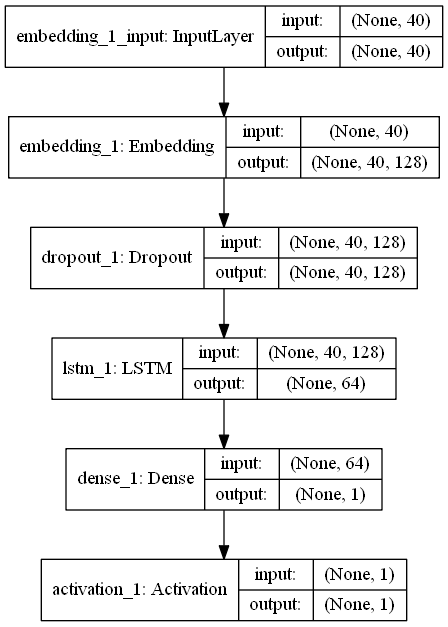

In [11]:
from keras.utils import plot_model
plot_model(model, to_file='./model.png', show_shapes='t')

40語の文章　→　単語ごとに分散表現に変換し分散表現の系列に　→　分散表現の系列がLSTMへ入力　→　出力を1つに

In [12]:
# 学習
history = model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=(Xtest, ytest))

d:\python_projects\ml_study_projects\tf_gpu\.venv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 9s 2ms/step - loss: 0.3307 - accuracy: 0.8536 - val_loss: 0.1015 - val_accuracy: 0.9626
Epoch 2/10
5668/5668 [==============================] - 8s 1ms/step - loss: 0.0549 - accuracy: 0.9822 - val_loss: 0.0487 - val_accuracy: 0.9824
Epoch 3/10
5668/5668 [==============================] - 8s 1ms/step - loss: 0.0248 - accuracy: 0.9917 - val_loss: 0.0478 - val_accuracy: 0.9824
Epoch 4/10
5668/5668 [==============================] - 8s 1ms/step - loss: 0.0137 - accuracy: 0.9963 - val_loss: 0.0379 - val_accuracy: 0.9887
Epoch 5/10
5668/5668 [==============================] - 8s 1ms/step - loss: 0.0104 - accuracy: 0.9970 - val_loss: 0.0409 - val_accuracy: 0.9894
Epoch 6/10
5668/5668 [==============================] - 8s 1ms/step - loss: 0.0077 - accuracy: 0.9977 - val_loss: 0.0465 - val_accuracy: 0.9894
Epoch 7/10
5668/5668 [==============================] - 8s 1ms/step - loss: 0.0046 - acc

In [13]:
# evaluate
score, acc = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)
print("Test score: {:.3f}, accuracy: {:.3f}".format(score, acc))

for i in range(5):
    idx = np.random.randint(len(Xtest))
    xtest = Xtest[idx].reshape(1, 40)
    ylabel = ytest[idx]
    ypred = model.predict(xtest)[0][0]
    sent = " ".join([index2word[x] for x in xtest[0].tolist() if x != 0])
    print("{:.0f}\t{:.0f}\t{}".format(ypred, ylabel, sent))

1418/1418 [==============================] - 0s 334us/step
Test score: 0.045, accuracy: 0.991
1	1	brokeback mountain was so awesome .
1	1	man i loved brokeback mountain !
0	0	he thinks harry potter is evil ( for real ) but i can get past it .
0	0	i hate harry potter , it 's retarted , gay and stupid and there 's only one black guy ...
0	0	is it just me , or does harry potter suck ? ...
